In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchinfo

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns
from ML_fctns import *

from datetime import datetime
from dateutil.relativedelta import relativedelta
from suntimes import SunTimes  

In [2]:
def get_comparison_frame(savename, TS_model, dl, bce=False, CNN=False):
    model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
    model_path = os.path.join(model_dir, savename + ".pt")
    checkpoint = torch.load(model_path, weights_only=True)
    TS_model.load_state_dict(checkpoint['model_state_dict'])
    list_logs = []
    list_observed = []
    list_stations = []
    list_years = []
    for xb, yb in dl:
        with torch.no_grad():
            if CNN:
                list_logs.append(TS_model(xb))
            else:
                list_logs.append(TS_model(xb.transpose(1, 2)))
            list_years.append(xb[:, 4, 0])
            list_stations.append(xb[:, 5, 0])
            #print(TS_model(xb.transpose(1, 2)))
        list_observed.append(yb)
    logs = torch.squeeze(torch.cat(list_logs))
    stations = torch.squeeze(torch.cat(list_stations))
    years = torch.squeeze(torch.cat(list_years))
    if bce:
        fitted = torch.round(logs)
    else:
        fitted = torch.argmax(logs, dim=2)
    L = fitted.shape[1]
    fitted_days = L - fitted.sum(dim=1)
    observed = torch.cat(list_observed)
    observed_days = L - observed.sum(dim=1)
    #print(stations.numpy().squeeze())
    comparison_frame = pd.DataFrame({'Stations_id': stations.numpy().squeeze(), 'year': years.numpy().squeeze(), 'fitted': fitted_days.numpy().squeeze(), 'observed': observed_days.numpy().squeeze()})
    return comparison_frame
    

In [ ]:
class MMDLoss(nn.Module):
    def __init__(self, weight):
        super(CustomLoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        # Compute the loss
        loss = torch.mean(self.weight * (input - target) ** 2)
        return loss

In [3]:
def CausalConv1d(in_channels, out_channels, kernel_size, dilation=1, **kwargs):
   pad = (kernel_size - 1) * dilation
   return nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)

class Causal_CNN_Classifier_KG(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, KG = True, MMD=False, target_features = torch.Tensor([0])):
        super(Causal_CNN_Classifier_KG, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.KG = KG

        self.target_features = target_features
        self.MMD = MMD

        self.activation = nn.LeakyReLU(negative_slope=0.01)

        #self.wavenet_block1 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(1, 5)]
        #self.wavenet_block2 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(5)]
        #self.wavenet_block3 = [CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2**n) for n in range(5)]

        self.conv1 = CausalConv1d(n_channels, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv2 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv3 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv4 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv5 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv6 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv7 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.conv8 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv9 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv10 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv11 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv12 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv13 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv14 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.conv15 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=1)#stride=3,
        self.conv16 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=2)
        self.conv17 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=4)#stride=3, 
        self.conv18 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=8)
        self.conv19 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=16)
        self.conv20 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=32)
        self.conv21 = CausalConv1d(hidden_dim, hidden_dim, kernel_size=2, dilation=64)
        self.wave1 = [self.conv1, self.conv2, self.conv3, self.conv4, 
                                  self.conv5, self.conv6, self.conv7]
        self.wave2 = [self.conv8, 
                      self.conv9, self.conv10, self.conv11, self.conv12, 
                      self.conv13, self.conv14]
        self.wave3 = [self.conv15, self.conv16,
                      self.conv17, self.conv18, self.conv19, 
                      self.conv20, self.conv21]
        if self.num_layers == 1:
            self.full_waves = self.wave1
        if self.num_layers == 2:
            self.full_waves = self.wave1 + self.wave2
        if self.num_layers == 3:
            self.full_waves = self.wave1 + self.wave2 + self.wave3

        self.fc = nn.Linear(hidden_dim, output_dim)  # Fully connected layer for classification
        
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)

        self.sig = nn.Sigmoid()

        self.u0 = torch.nn.Parameter(torch.Tensor([1]))
        self.u1 = torch.nn.Parameter(torch.Tensor([0]))
        self.u2 = torch.nn.Parameter(torch.Tensor([0]))
        self.u3 = torch.nn.Parameter(torch.Tensor([0]))

        self.p0 = torch.nn.Parameter(torch.Tensor([13]))
        

    def forward(self, x0):
        x = x0[:, :self.input_dim, :]
        #print(x.max())
        #print(x0.shape)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) # Initialize cell state
        # Apply Wang Engel
        T_min = 9 + 10*(torch.tanh(self.u1)) - 4 #normally multiplier = 2
        T_opt = 28 + 7*(torch.tanh(self.u2)) - 4 #normally multiplier = 3
        T_max = 39 + 3.5*torch.tanh(self.u3) - 4 #normally no multiplier
        alpha = np.log(2)/torch.log( (T_max - T_min)/(T_opt - T_min) )
        beta = 1
        #print(T_min, T_opt, T_max)
        #print(alpha)
        #print(((2*(x - T_min)*(x >= T_min))**alpha))
        #print(x.max())
        if self.KG:
            x[:, 0, :] = ( ( ((2*(x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, 0, :] - T_min)*(x[:, 0, :] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        #x = torch.nan_to_num(x)
        #x = x*(x >= T_min)*(x<= T_max)
        #print(x)
        #print(x, x.shape)
        # Make cumulative
        #x[:, 0, :] = self.u0*torch.cumsum(x[:, 0, :], dim = 1)
        #print(x.max())
        if self.input_dim == 3:
            x[:, :, 1] = 0.5*(1 + torch.tanh(2*(x[:, :, 1] - self.p0)))
        # Forward pass through convnet
        #for i, conv in enumerate([self.conv1, self.conv2, self.conv3, self.conv4, 
        #                          self.conv5, self.conv6, self.conv7, self.conv8, 
        #                          self.conv9, self.conv10, self.conv11, self.conv12, 
        #                          self.conv13, self.conv14, self.conv15, self.conv16,
        #                          self.conv17, self.conv18, self.conv19, self.conv20]):
        for i, conv in enumerate(self.full_waves):
            #print(i)
            #print(x.shape)
            #print(conv)
            x = conv(x)
            x = x[:, :, :-conv.padding[0]]
            #print()
            #x[:, :, 0] = ( ( ((2*(x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**alpha)*((T_opt - T_min)**alpha) - (((x[:, :, 0] - T_min)*(x[:, :, 0] >= T_min))**(2*alpha)) ) / ((T_opt - T_min)**(2*alpha)) )**beta
        
            x = self.activation(x)
        #print(x.shape)
        #x, (hn, cn) = self.lstm(torch.swapaxes(x, 2, 1), (h0, c0)) #self.lstm(x, (h0, c0)) #
        #x = torch.swapaxes(x, 1, 2)
        # output: (batch, seq_len, hidden_dim)
        #torch.nn.init.xavier_uniform(self.fc.weight)
        # Get the hidden state of the last time step
        # output[:, -1, :] is more efficient for batch_first=True
        #last_hidden = output[:, -1, :] # (batch, hidden_dim)
        #print(self.fc(output))
        
        # Classify all layers using fully connected layer
        out_space = torch.swapaxes(self.fc(torch.swapaxes(x, 2, 1)), 1, 2) # (batch, output_dim)
        if self.output_dim == 1:
            out_scores = self.sig(out_space)
        else:
            out_scores = F.log_softmax(out_space, dim=2)
        #print(out_scores.max())
        return out_scores

In [9]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
print(len(ds_inputs_DE))
ds_inputs_DE = ds_inputs_DE.dropna(how='any')
print(len(ds_inputs_DE))
#ds_inputs_DE = ds_inputs_DE.loc[ds_inputs_DE['observed time to beginning of flowering'] < 120]
skip = 1
numsteps = int(163 // skip)
NDVI_series_DE = torch.Tensor(ds_inputs_DE[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_DE = ((NDVI_series_DE - NDVI_series_DE.min(dim=1)[0].unsqueeze(1))/(NDVI_series_DE.max(dim=1)[0] - NDVI_series_DE.min(dim=1)[0]).unsqueeze(1))
temp_series_DE = torch.Tensor(ds_inputs_DE[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_DE = torch.Tensor((ds_inputs_DE[[f'photoperiod at day {56 + skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_DE = torch.Tensor(ds_inputs_DE[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_DE = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_DE))])
year_series_DE = torch.Tensor([ds_inputs_DE['year'] for count in range(numsteps)]).T
id_series_DE = torch.Tensor([ds_inputs_DE['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE, NDVI_series_DE, day_series_DE, year_series_DE, id_series_DE)), 0, 1)#, photoperiod_series_DE
NDVI_labels_DE = torch.Tensor(ds_inputs_DE[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values) #torch.Tensor(ds_inputs_DE['observed time to beginning of flowering'].astype('int64').values)

2224
2203


In [10]:
#ds_inputs_SSA = ds_inputs_SSA.loc[ds_inputs_SSA['observed time to beginning of flowering'] < 110]
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
skip = 1
numsteps = int(163 // skip)
NDVI_series_SSA = torch.Tensor(ds_inputs_SSA[[f'NDVI interpolated at day {skip*n}' for n in range(numsteps)]].values)#12
#NDVI_series_SSA = ((NDVI_series_SSA - NDVI_series_SSA.min(dim=1)[0].unsqueeze(1))/(NDVI_series_SSA.max(dim=1)[0] - NDVI_series_SSA.min(dim=1)[0]).unsqueeze(1))
temp_series_SSA = torch.Tensor(ds_inputs_SSA[[f'temperature at day {skip*n}' for n in range(numsteps)]].values)
#photoperiod_series_SSA = torch.Tensor((ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]] > 11).astype(int).values)#12
photoperiod_series_SSA = torch.Tensor(ds_inputs_SSA[[f'photoperiod at day {skip*n}' for n in range(numsteps)]].values)#12
day_series_SSA = torch.Tensor([[skip*n for n in range(numsteps)] for count in range(len(ds_inputs_SSA))])
year_series_SSA = torch.Tensor([ds_inputs_SSA['year'] for count in range(numsteps)]).T
id_series_SSA = torch.Tensor([ds_inputs_SSA['Stations_id'] for count in range(numsteps)]).T
temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1) #, photoperiod_series_SSA
NDVI_labels_SSA = torch.Tensor(ds_inputs_SSA[[f'dev stage at day {skip*n}' for n in range(numsteps)]].astype('int64').values)

0 0.6884845495223999 0.6750583052635193
5 0.5275811553001404 0.41501736640930176
10 0.4205378592014313 0.46047699451446533
15 0.577424168586731 0.5044066309928894
20 0.45600324869155884 0.4263026714324951
25 0.37132057547569275 0.32618340849876404
30 0.25074633955955505 0.2035784274339676
35 0.3138565123081207 0.10942896455526352
40 0.17276892066001892 0.10640158504247665
45 0.1624867022037506 0.11472593247890472
50 0.15115530788898468 0.0905889943242073
55 0.14661385118961334 0.09170626848936081
60 0.1441531628370285 0.09447610378265381
65 0.14144748449325562 0.08586873859167099
70 0.13937711715698242 0.09350503981113434
75 0.13819743692874908 0.09282564371824265
80 0.13675162196159363 0.09224528074264526
85 0.13981421291828156 0.11103712022304535
90 0.13672345876693726 0.09913252294063568
95 0.13724131882190704 0.09203193336725235
100 0.13704094290733337 0.09085115045309067
105 0.13640718162059784 0.0887371376156807
110 0.13532792031764984 0.09024903923273087
115 0.13517682254314423 

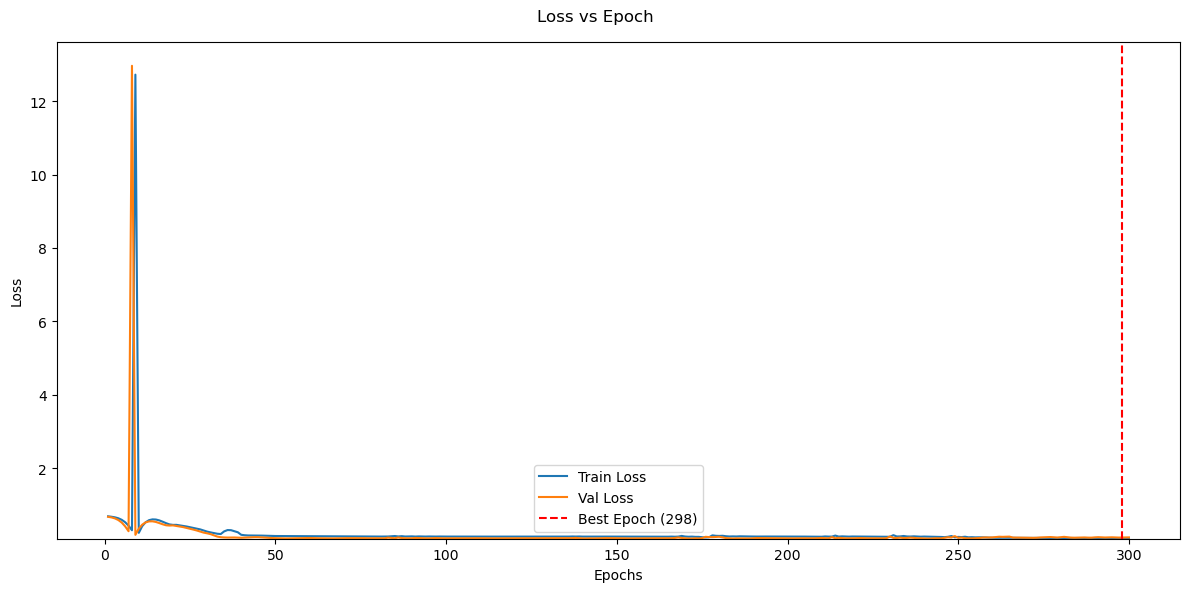

In [66]:
bs = 500
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 32
num_layers = 3
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_SAT_pp_KG_SSA'

bce = True
CNN = True

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 300
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([-0.3998])), ('u2', tensor([1.1349])), ('u3', tensor([-0.8923])), ('p0', tensor([13.])), ('conv1.weight', tensor([[[ 0.7586,  0.6180],
         [-0.0261, -0.0606],
         [ 0.2255, -0.1257],
         [ 0.2959,  0.0729]],

        [[-0.0574, -0.2249],
         [-0.3449, -0.2743],
         [-0.1054, -0.3395],
         [-0.0019,  0.1648]],

        [[ 0.7632,  0.5358],
         [-0.2796, -0.3774],
         [ 0.2191,  0.1369],
         [ 0.1325,  0.3065]],

        [[-0.5023, -0.1694],
         [ 0.0411,  0.1644],
         [ 0.0276, -0.2462],
         [-0.2277,  0.1110]],

        [[-0.2066,  0.2207],
         [-0.2050, -0.3611],
         [-0.1002,  0.0785],
         [ 0.1106,  0.3026]],

        [[-0.1194, -0.8153],
         [ 0.0352,  0.0150],
         [-0.3653,  0.1530],
         [-0.2950,  0.1863]],

        [[ 0.1070, -0.1419],
         [ 0.2073,  0.0822],
         [ 0.1372,  0.0706],
         [ 0.1169, -0.0463]],

        [[ 0.2506, 

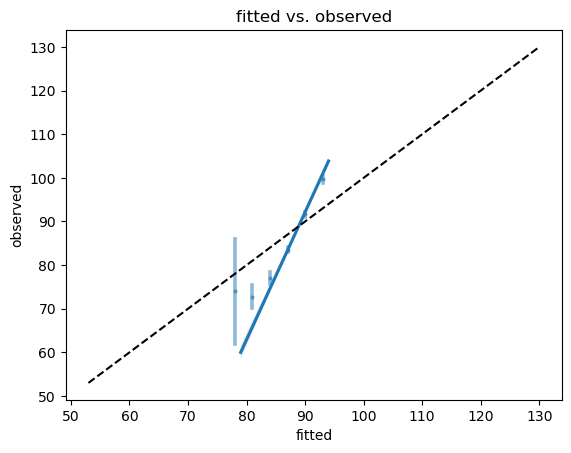

In [69]:
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
#save_name = 'CCNN_SAT_pp_KG'
#bce = True
#CNN = True
#model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG = True)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [21]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4
num_layers = 1
output_dim = 1  # Example: 5 classes
KG = True

epochs = 2500
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.07992878708476782
Fold 2
Loss: 0.07773031334939258
Fold 3
Loss: 0.08086830956880404
Fold 4
Loss: 0.08106060567831222
Fold 5
Loss: 0.0807809119899369


In [24]:
print_results(loss_values_raw, R2s_raw, Biases_raw, Variances_raw, title = 'Causal CNN with KG')

#### Causal CNN with KG ####
loss 0.08135979771614074 +/- 0.0014518389680607741
R2 0.551973295211792 +/- 0.009248979280957144
Bias 0.49621304869651794 +/- 0.22074940702617724
Variance 63.76042785644531 +/- 1.1013022561824086


In [19]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### Causal CNN no KG ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

#### Causal CNN no KG ####
loss 0.0829683005809784 +/- 0.0023356553205011584
R2 0.5423917055130005 +/- 0.01801321849186073
Bias 1.4350961446762085 +/- 1.0249130391623942
Variance 67.46737594604492 +/- 1.8934418222478935


In [30]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4
num_layers = 1
output_dim = 1  # Example: 5 classes
KG = False

epochs = 2500
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_SSA, R2s_SSA, Biases_SSA, Variances_SSA = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.08623763173818588
Fold 2
Loss: 0.0916554406285286
Fold 3
Loss: 0.0827585905790329
Fold 4
Loss: 0.08741223067045212
Fold 5
Loss: 0.07524872571229935


In [33]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 4
num_layers = 1
output_dim = 1  # Example: 5 classes
KG = True

epochs = 2500
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_SSA_KG, R2s_SSA_KG, Biases_SSA_KG, Variances_SSA_KG = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.09451353549957275
Fold 2
Loss: 0.09396106004714966
Fold 3
Loss: 0.08914792537689209
Fold 4
Loss: 0.0805366188287735
Fold 5
Loss: 0.08512367308139801


In [32]:
print_results(loss_values_SSA, R2s_SSA, Biases_SSA, Variances_SSA, title = 'Causal CNN SSA no KG')

#### Causal CNN SSA no KG ####
loss 0.126229989528656 +/- 0.0246615596276387
R2 0.42439320087432864 +/- 0.05920390117292838
Bias 5.195734024047852 +/- 3.3216635243565493
Variance 64.90566024780273 +/- 4.162811210059701


In [34]:
print_results(loss_values_SSA_KG, R2s_SSA_KG, Biases_SSA_KG, Variances_SSA_KG, title = 'Causal CNN SSA KG')

#### Causal CNN SSA KG ####
loss 0.11093353480100632 +/- 0.007850556949434597
R2 0.413174045085907 +/- 0.052062620811368795
Bias 3.0364651679992676 +/- 2.001748876704373
Variance 55.041561889648435 +/- 2.1885512147430295


In [23]:
def print_results(loss_values_raw, R2s_raw, Biases_raw, Variances_raw, title = 'Causal CNN'):
    score = np.mean(loss_values_raw)
    score_stde = np.std(loss_values_raw)/np.sqrt(5)
    R2_score = np.mean(R2s_raw)
    R2_stde = np.std(R2s_raw)/np.sqrt(5)
    Bias_score = np.mean(np.array(Biases_raw)**2)
    Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
    Variance_score = np.mean(Variances_raw)
    Variance_stde = np.std(Variances_raw)/np.sqrt(5)
    print(f'#### {title} ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
Bias_score = np.mean(np.array(Biases_raw)**2)
Bias_stde = np.std(np.array(Biases_raw)**2)/np.sqrt(5)
Variance_score = np.mean(Variances_raw)
Variance_stde = np.std(Variances_raw)/np.sqrt(5)
print(f'#### Causal CNN no KG SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}\nBias {Bias_score} +/- {Bias_stde}\nVariance {Variance_score} +/- {Variance_stde}')

In [20]:
Biases_raw

[-2.4331055, 0.01133728, -1.1088486, -0.1454544, -0.06817627]

In [109]:
input_dim = 4
savename = 'CCNN_KG_SAT_pp' #'LSTM_KG_SAT_pp'
model_dir = 'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\ML_algorithms\\saved_models\\'
model_path = os.path.join(model_dir, savename + ".pt")
checkpoint = torch.load(model_path, weights_only=True)
model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =True) #LSTMClassifier_KG(input_dim, hidden_dim, num_layers, output_dim)
model.load_state_dict(checkpoint['model_state_dict'])
for param in model.parameters():
    param.requires_grad = False
for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
    param.requires_grad = True
#for param in model.fc.parameters():
#    param.requires_grad = False
#for param in model.lstm.parameters():
#    param.requires_grad = False
#for param in [model.u0, model.u1, model.u2, model.u3, model.p0]:
#    param.requires_grad = True
#for param in [model.u2]: #[model.u1, model.u2, model.u3]:
#    param.requires_grad = False


0 0.1645112782716751 0.12104088068008423
5 0.1496516317129135 0.11885784566402435
10 0.1495489627122879 0.12204373627901077
15 0.14721916615962982 0.11986470222473145
20 0.1461344212293625 0.11916853487491608
25 0.1467435210943222 0.11923599988222122
30 0.14669056236743927 0.11887209862470627
35 0.1462346315383911 0.11920380592346191
40 0.14614492654800415 0.11870492249727249
45 0.1462034434080124 0.11869876086711884
50 0.14619655907154083 0.11879435926675797
55 0.14617575705051422 0.11867369711399078
60 0.14614753425121307 0.11879819631576538
65 0.14613746106624603 0.11870381981134415
70 0.14612658321857452 0.11875616759061813
75 0.1461213231086731 0.11874970048666
80 0.14611610770225525 0.11874973028898239
85 0.14611540734767914 0.11878764629364014
90 0.1461164355278015 0.11876621842384338
95 0.14611296355724335 0.11876627057790756
100 0.14611302316188812 0.11878328025341034
105 0.14611183106899261 0.11877395212650299
110 0.14611047506332397 0.11876997351646423
115 0.1461100727319717

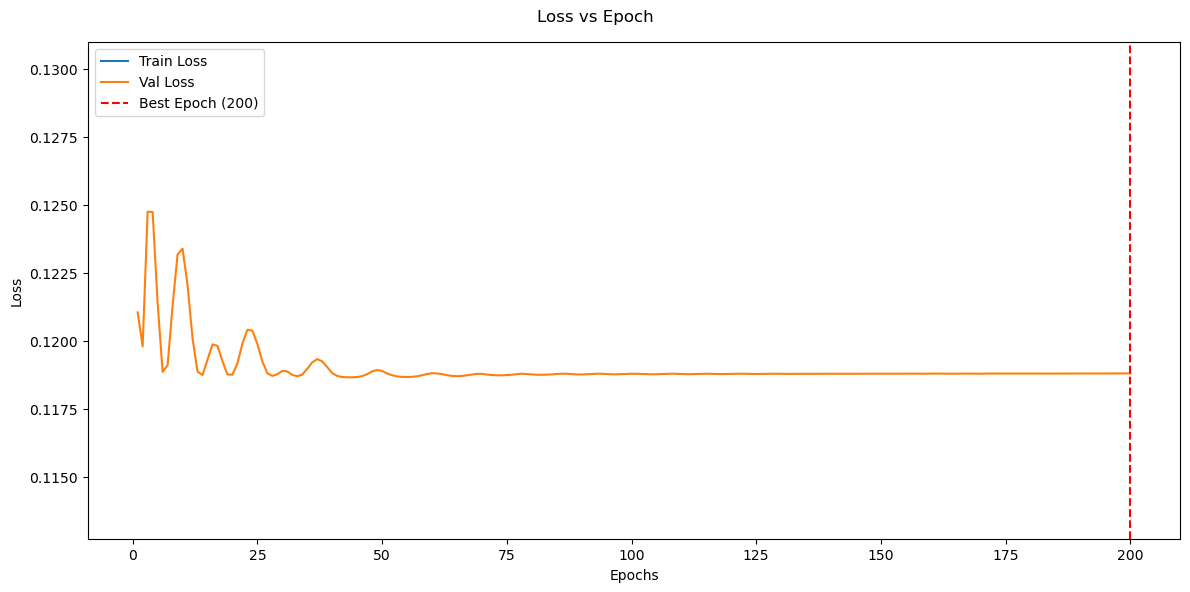

In [110]:
bs = 500
n_channels = 4
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.5)

# Loss function and optimizer
criterion = criterion = nn.BCELoss()#nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 200
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = 'CCNN_KG_pp_SSA_TL', CNN=True, bce = True)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([0.])), ('u2', tensor([0.])), ('u3', tensor([0.])), ('p0', tensor([13.])), ('conv1.weight', tensor([[[-0.1174, -0.3636],
         [ 0.4414, -0.1640],
         [-0.1762, -0.4002],
         [ 0.0311, -0.3446]],

        [[ 0.0590, -0.1536],
         [ 0.8263,  0.3573],
         [ 0.3236,  0.1303],
         [-0.0806,  0.1269]],

        [[ 0.1690, -0.0802],
         [-0.1537, -0.0684],
         [-0.2250,  0.1923],
         [-0.5362, -0.5046]],

        [[ 0.3433,  0.5566],
         [-0.2442,  0.2170],
         [ 0.4630,  0.7102],
         [-0.1885,  0.3333]],

        [[-0.1359, -0.1335],
         [ 0.0651, -0.0101],
         [ 0.3714,  0.5093],
         [-0.0275, -0.3219]],

        [[-0.4781, -0.5681],
         [ 0.0864,  0.4411],
         [-0.2269, -0.7360],
         [ 0.0887,  0.2307]],

        [[ 0.4111, -0.0382],
         [ 0.2282, -0.0714],
         [ 0.4114,  0.9449],
         [-0.3073,  0.1466]],

        [[-0.1431,  0.4669],
    

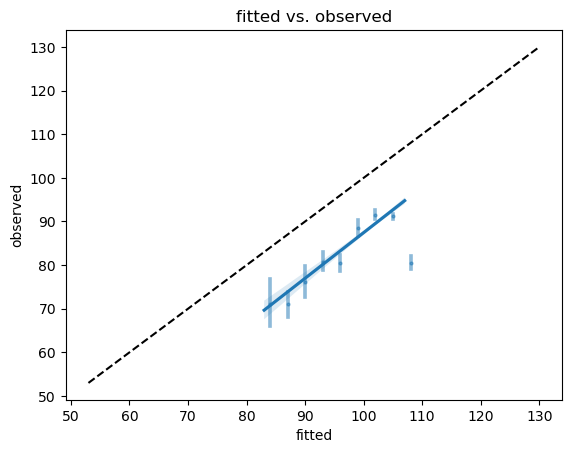

In [16]:
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_DE, method = 'regression', bce=bce, CNN=CNN)#

In [49]:
comparison_frame = get_comparison_frame(save_name, model, val_dl_DE, bce=bce, CNN=CNN)

In [50]:
comparison_frame['fitted'] = comparison_frame['fitted'] - comparison_frame['fitted'].mean()
comparison_frame['observed'] = comparison_frame['observed'] - comparison_frame['observed'].mean()

In [51]:
r2_score(comparison_frame['observed'], comparison_frame['fitted'])

0.08216637372970581

<Axes: xlabel='fitted', ylabel='observed'>

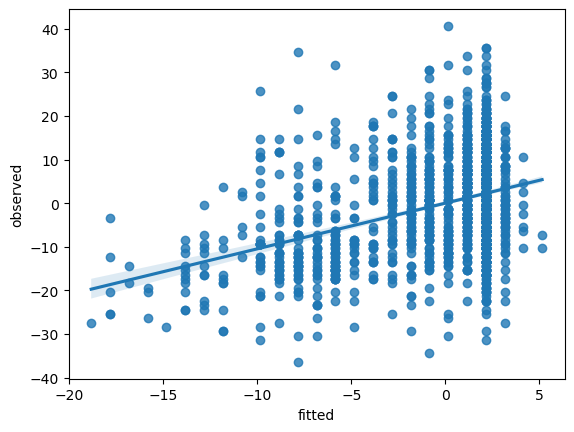

In [20]:
sns.regplot(x = 'fitted', y = 'observed', data = comparison_frame)

<Axes: xlabel='observed', ylabel='Count'>

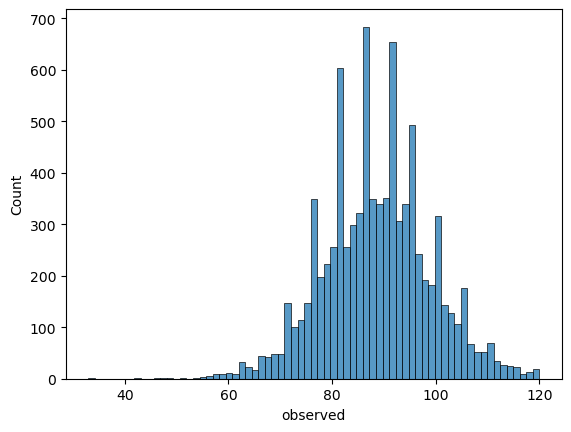

In [125]:
sns.histplot(comparison_frame['observed'])

In [53]:
def plot_residuals(comparison_frame):
    fig, axs = plt.subplots(1, 2)
    comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
    sns.histplot(comparison_frame['residuals'], ax = axs[0])
    maxval = max(comparison_frame['fitted'].max(), comparison_frame['residuals'].max())
    minval = min(comparison_frame['fitted'].min(), comparison_frame['residuals'].min())
    
    sns.regplot(x='fitted', y='residuals', data = comparison_frame, ax=axs[1],
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 1),
                fit_reg = False)
    axs[1].axhline(0, color = 'black')

In [54]:
def comp_histogram(comparison_frame, title = 'Histogram fitted observed'):
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = comparison_frame, ax=ax, label = 'fitted',
                stat = 'density')
    sns.histplot(x='observed', data = comparison_frame, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

R^2 value for model: 0.08216637372970581
Bias: 1.3145204744080806e-12
Variance of modelled values: 3.6720290184020996


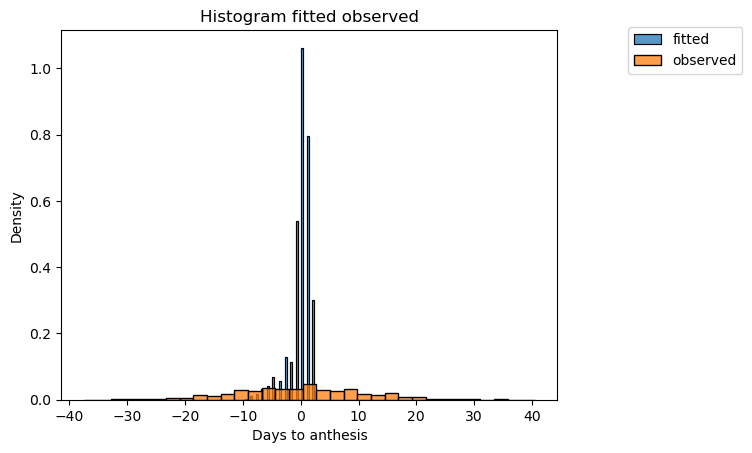

In [55]:
comp_histogram(comparison_frame)

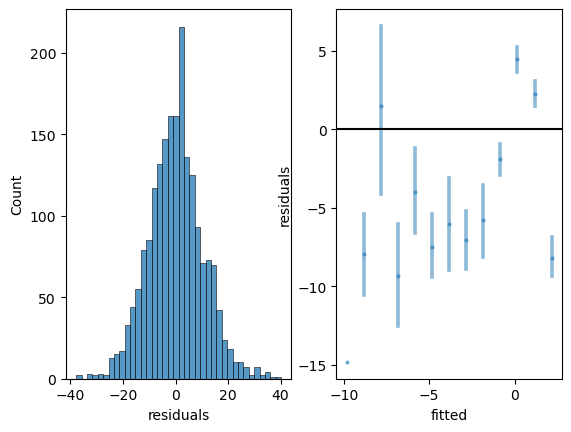

In [56]:
plot_residuals(comparison_frame)

In [ ]:
fig, axs = plt.subplots()
sns.regplot(x='fitted', y='residuals', data = cf, ax=ax,
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
                fit_reg = False)

In [49]:
comparison_frame['residuals'] = comparison_frame['observed'] - comparison_frame['fitted']
comparison_frame.loc[~((comparison_frame['fitted'] > 100)*(comparison_frame['residuals'] > 10))]#.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\overestimate.csv')
comparison_frame.loc[comparison_frame['observed'] > 120].to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\late_flowering.csv')

In [98]:
bs = 500
n_channels = 4

input_dim = n_channels # Example: 100-dimensional word embeddings
output_dim = 1  # Example: 5 classes

epochs = 30
model_class = Causal_CNN_Classifier_KG
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, train_proportion=1)

CNN = True
bce = True

k_folds = 5

for num_layers in [1, 2, 3]:
    for hidden_dim in [16]:
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

Fold 1
Loss: 0.0886116771890529
Fold 2
Loss: 0.08836373065604436
Fold 3
Loss: 0.08951394303174352
Fold 4
Loss: 0.0882405449773102
Fold 5
Loss: 0.08888193044230566
1 layers
hidden dim 16
loss 0.09006356248548063 +/- 0.0029337343981179036
R2 0.3842145919799805 +/- 0.0316193425945896
Fold 1
Loss: 0.08861211669257428
Fold 2
Loss: 0.08848984463686453
Fold 3
Loss: 0.08975609844555536
Fold 4
Loss: 0.08975120264626958
Fold 5
Loss: 0.08916666366397281
2 layers
hidden dim 16
loss 0.0911295287568484 +/- 0.0037888759662498142
R2 0.3741725325584412 +/- 0.04534479351049852
Fold 1
Loss: 0.08924290149158369
Fold 2
Loss: 0.09043035772493943
Fold 3
Loss: 0.09061214745940353
Fold 4
Loss: 0.09035677325105906
Fold 5
Loss: 0.09013886576669533
3 layers
hidden dim 16
loss 0.09201111013619959 +/- 0.0026411091779612824
R2 0.35802420377731325 +/- 0.0321787427596478


In [99]:
for num_layers in [1]:
    for hidden_dim in [8, 16, 32]:
        CNN_args = (input_dim, hidden_dim, num_layers, output_dim)
        loss_values, R2s, Biases, Variances = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, CNN_args, savename_prefix = 'KFold', loss = 'BCE', CNN=CNN, bce=bce)
        score = np.mean(loss_values)
        score_std = np.std(loss_values)
        R2_score = np.mean(R2s)
        R2_std = np.std(R2s)
        print(f'{num_layers} layers\nhidden dim {hidden_dim}\nloss {score} +/- {score_std}\nR2 {R2_score} +/- {R2_std}')

Fold 1
Loss: 0.08871571966076906
Fold 2
Loss: 0.08948202849041796
Fold 3
Loss: 0.08887378234975064
Fold 4
Loss: 0.08866631186317508
Fold 5
Loss: 0.08997446561430894
1 layers
hidden dim 8
loss 0.0900080360546399 +/- 0.001781744888513259
R2 0.3921561360359192 +/- 0.027771960836591062
Fold 1
Loss: 0.08872808187323458
Fold 2
Loss: 0.08920831392307398
Fold 3
Loss: 0.08905069422282881
Fold 4
Loss: 0.08849793934047906
Fold 5
Loss: 0.08938197528648635
1 layers
hidden dim 16
loss 0.09003622978258721 +/- 0.0013705386912874961
R2 0.3800978422164917 +/- 0.017306412481303074
Fold 1
Loss: 0.08868540235255894
Fold 2
Loss: 0.08809042044102139
Fold 3
Loss: 0.08923776981316427
Fold 4
Loss: 0.08936428121850519
Fold 5
Loss: 0.08978191455740875
1 layers
hidden dim 32
loss 0.08911869591641473 +/- 0.002350894508984044
R2 0.3945940375328064 +/- 0.02463562727769248


In [ ]:
bs = 500
n_channels = 3

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes
KG = False

epochs = 200
temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, photoperiod_series_DE
train_ds, val_ds = train_test_ds_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, train_proportion=1)
k_folds = 5
model_args = (input_dim, hidden_dim, num_layers, output_dim, KG)

model_class = Causal_CNN_Classifier_KG

loss_values_raw, R2s_raw, Biases_raw, Variances_raw = K_fold_crossval(k_folds, train_ds, model_class, epochs, bs, model_args, savename_prefix = 'KFold', freeze_params=True, loss='BCE', bce=True, CNN=True)

Fold 1
Loss: 0.09318297356367111
Fold 2
Loss: 0.08788973093032837
Fold 3
Loss: 0.0820319727063179
Fold 4
Loss: 0.10063453018665314
Fold 5
Loss: 0.08032040297985077


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE no SAT big data ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE no SAT big data ####
loss 0.08600211074215718 +/- 0.0017534131635885345
R2 0.3106345057487488 +/- 0.023533859321335185


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet SSA ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet SSA ####
loss 0.10788502544164658 +/- 0.015933853744630414
R2 0.34511895179748536 +/- 0.04444457263756812


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE no SAT ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE no SAT ####
loss 0.07681606709957123 +/- 0.0005721705533491635
R2 0.46258920431137085 +/- 0.02771426296112305


In [ ]:
score = np.mean(loss_values_raw)
score_stde = np.std(loss_values_raw)/np.sqrt(5)
R2_score = np.mean(R2s_raw)
R2_stde = np.std(R2s_raw)/np.sqrt(5)
print(f'#### wavenet DE ####\nloss {score} +/- {score_stde}\nR2 {R2_score} +/- {R2_stde}')

#### wavenet DE ####
loss 0.0777890920639038 +/- 0.002083252406613548
R2 0.44964544773101806 +/- 0.02450198208101182


0 0.6984400153160095 0.6992695927619934
5 0.694288432598114 0.694058358669281
10 0.6849463582038879 0.6817994117736816
15 0.667435884475708 0.6616533398628235
20 0.6315533518791199 0.610995888710022
25 0.49984678626060486 0.46639207005500793
30 0.39766764640808105 0.3497906029224396
35 0.31247180700302124 0.2714967727661133
40 0.3918214738368988 0.28000277280807495
45 0.2418716847896576 0.23113250732421875
50 0.21971221268177032 0.21990355849266052
55 0.1947033703327179 0.2067577838897705
60 0.17662844061851501 0.1826513558626175
65 0.16364209353923798 0.1774725317955017
70 0.1560198813676834 0.1700506955385208
75 0.15162011981010437 0.16829687356948853
80 0.14823728799819946 0.16124635934829712
85 0.14448587596416473 0.15883471071720123
90 0.13992725312709808 0.1505986452102661
95 0.13553296029567719 0.1411682516336441
100 0.12704592943191528 0.12232084572315216
105 0.12066115438938141 0.11197680979967117
110 0.1136101633310318 0.10082265734672546
115 0.1203799918293953 0.098160542547

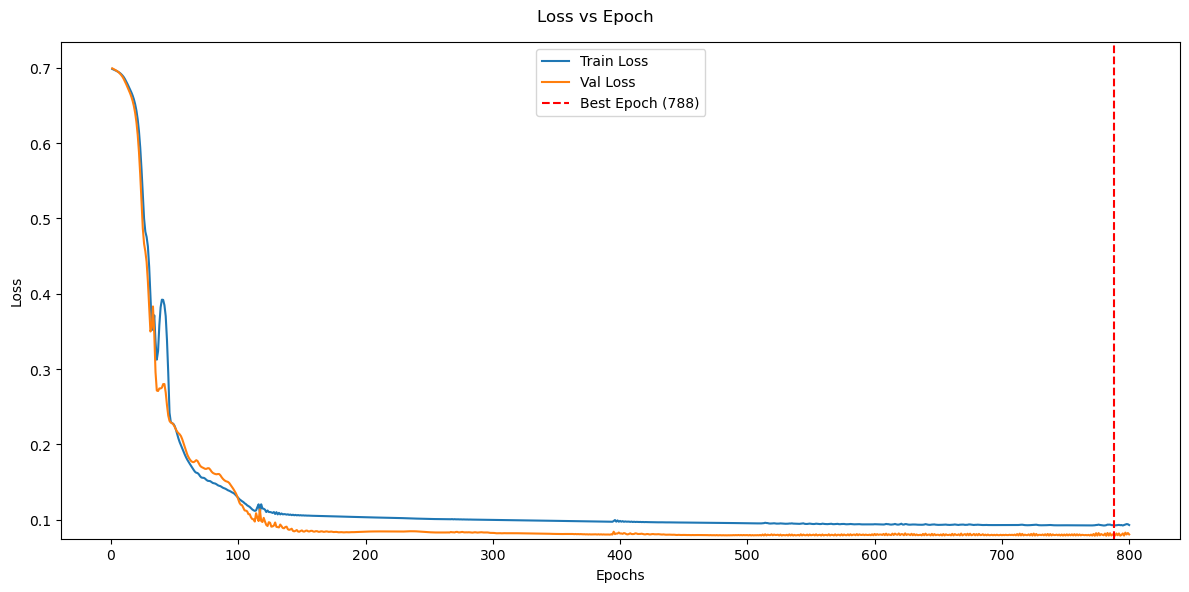

In [13]:
bs = 500
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.95)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 8
num_layers = 2
output_dim = 1  # Example: 5 classes
KG = False


save_name = 'CCNN_SAT_pp_SSA'

bce = True
CNN = True

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =False)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 800
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

0 0.6904991139175018 0.6838299036026001
5 0.4063269587372948 0.3022230267524719
10 0.1907837125927172 0.1636435091495514
15 0.12289453623639314 0.1160309761762619
20 0.10839521000102748 0.10246682912111282
25 0.10299866752290605 0.09733667969703674
30 0.0995094221562185 0.09390465170145035
35 0.09792811027875568 0.09426847100257874
40 0.09879955520950191 0.09084177762269974
45 0.09913513965253141 0.09954384714365005
50 0.09703523661889353 0.09058978408575058
55 0.09520540649899965 0.0901157557964325
60 0.0943201813275521 0.08892688155174255
65 0.09428218178007237 0.08907714486122131
70 0.09378774862627869 0.08765809237957001
75 0.09282217221039481 0.08718078583478928
80 0.09222851972200723 0.08690068125724792
85 0.09183431315709127 0.0866362452507019
90 0.09153728270183195 0.08631827682256699
95 0.09127028040937296 0.0860113576054573
100 0.09105295856000503 0.08575599640607834
105 0.0906468344561954 0.08517592400312424
110 0.09070671736929656 0.08496306091547012
115 0.09062736212300711

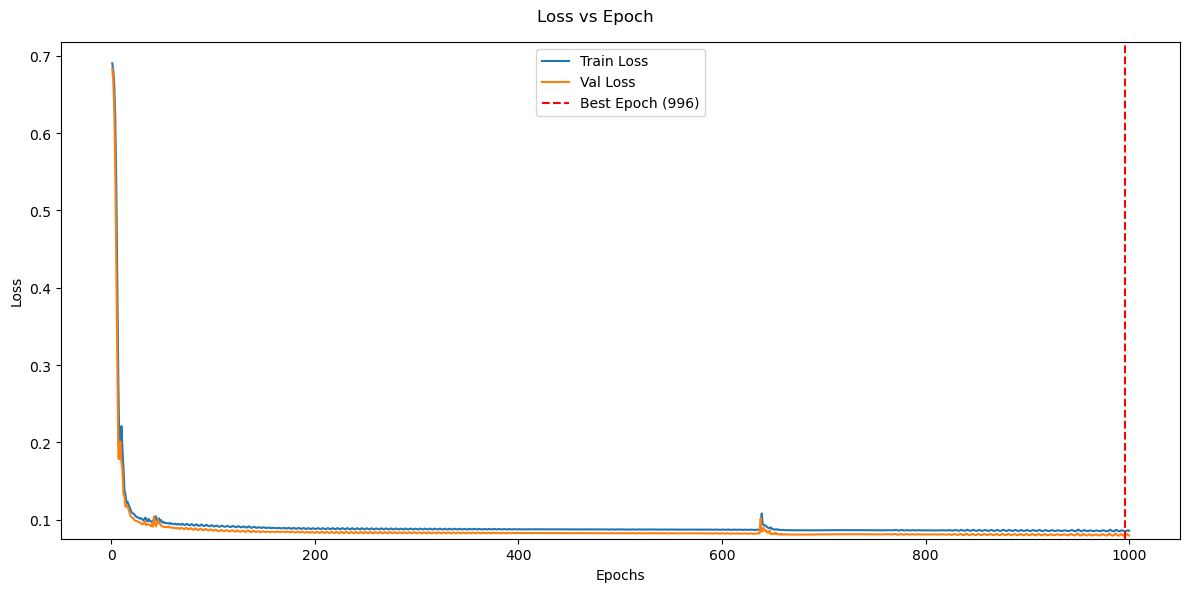

In [136]:
bs = 500
n_channels = 4
#temp_NDVI_series_DE = torch.swapaxes(torch.stack((temp_series_DE, photoperiod_series_DE)), 0, 1)#, NDVI_series_DE
#temp_NDVI_series_DE = torch.swapaxes(temp_NDVI_series_DE, 2, 1)
train_dl, val_dl = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels)

input_dim = n_channels # Example: 100-dimensional word embeddings
hidden_dim = 16
num_layers = 1
output_dim = 1  # Example: 5 classes


save_name = 'CCNN_KG_SAT_pp_small'

bce = True
CNN = True

model = Causal_CNN_Classifier_KG(input_dim, hidden_dim, num_layers, output_dim, KG =True)
#for param in [model.p0, model.u0, model.u1, model.u2, model.u3]:#[model.u2]: #
#    param.requires_grad = False

# Loss function and optimizer
criterion = nn.BCELoss() #nn.NLLLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

epochs = 1000
fit(epochs, model, criterion, optimizer, train_dl, val_dl, save_name = save_name, CNN = CNN, bce=bce)

OrderedDict([('u0', tensor([1.])), ('u1', tensor([-0.3724])), ('u2', tensor([-0.0713])), ('u3', tensor([-0.7030])), ('p0', tensor([13.])), ('conv1.weight', tensor([[[ 1.0524,  0.6248],
         [-0.0195, -0.3831],
         [-0.4891, -0.0242],
         [-0.1708, -0.1383]],

        [[-0.1743,  0.1651],
         [ 0.3480, -0.0657],
         [ 0.2169,  0.1282],
         [-0.2930,  0.3348]],

        [[-0.0929,  0.5035],
         [ 0.3486,  0.2373],
         [ 0.0355,  0.0290],
         [ 0.1001, -0.0834]],

        [[ 0.6965,  0.7562],
         [ 0.0236,  0.0674],
         [-0.2143,  0.0623],
         [-0.1774,  0.0949]],

        [[-0.9691, -1.0699],
         [-0.0703, -0.0429],
         [ 0.1628,  0.1416],
         [-0.3148,  0.3050]],

        [[ 0.9200,  0.8582],
         [ 0.1094,  0.3992],
         [ 0.1147,  0.0977],
         [-0.1799, -0.0961]],

        [[ 0.1700,  0.5237],
         [ 0.1965,  0.0801],
         [ 0.5478,  0.2747],
         [ 0.0151, -0.0224]],

        [[ 0.3049,

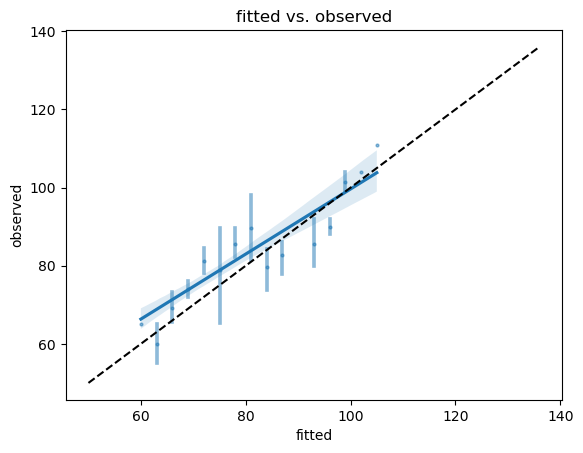

In [138]:
#save_name = 'CCNN_KG_SAT_pp_SSA' #save_name = 'CCNN_KG_SAT_pp'#'CCNN_KG_pp_SSA'#
#temp_NDVI_series_SSA = torch.swapaxes(torch.stack((temp_series_SSA, photoperiod_series_SSA, NDVI_series_SSA, day_series_SSA, year_series_SSA, id_series_SSA)), 0, 1)
train_dl_SSA, val_dl_SSA = train_test_dl_from_tensors(temp_NDVI_series_SSA, NDVI_labels_SSA, bs = bs, n_channels = n_channels, train_proportion=0.1)
train_dl_DE, val_dl_DE = train_test_dl_from_tensors(temp_NDVI_series_DE, NDVI_labels_DE, bs = bs, n_channels = n_channels, train_proportion=0.1)
plot_from_saved(save_name, model, val_dl_SSA, method = 'regression', bce=bce, CNN=CNN)#